# Hyperband Sampler Configuration Comparison

## Introduction

This notebook provides a hands-on exploration of different Hyperband configurations using a custom Optuna sampler implementation. Whether you're coming from my [blog post on building a Hyperband sampler](LINK_TO_BLOG) or stumbled upon this randomly, you'll get practical insights into how parameter choices actually affect optimization performance in the real world.

**What is Hyperband?** Hyperband is a resource-aware hyperparameter optimization algorithm that balances exploration (trying many configurations quickly) with exploitation (spending more resources on promising candidates). Think of it like a tournament bracket where configurations compete for resources, with weaker performers eliminated early so you can focus your computational budget on the most promising options.

**What You'll Actually Learn:**
- How `reduction_factor` controls the aggressiveness of elimination between rungs
- The tradeoff between exploratory vs exploitative bracket strategies  
- When to use different resource allocation approaches based on your actual constraints
- Real performance comparisons across multiple datasets and search spaces (not just toy examples)

**The Custom Implementation:** This notebook uses a PyTorch-compatible Hyperband sampler I built on top of Optuna, designed to overcome some annoying limitations in existing tools. Unlike Keras Tuner (which only works with TensorFlow), this implementation gives you full transparency into what the algorithm is actually doing while maintaining compatibility with any PyTorch workflow.

**Datasets Used:** We'll benchmark performance on several standard ML datasets including the UCI Letter Recognition dataset, comparing how different Hyperband configurations perform under various resource constraints and problem complexities. No MNIST here - we're using datasets that actually matter.

By the end, you'll have practical guidelines for choosing the right Hyperband parameters for your specific use case, whether you're optimizing neural networks, ensemble methods, or any other resource-intensive ML pipeline. Plus, you'll see exactly why some configurations work better than others instead of just taking my word for it.

Let's dive in and see what actually works.

## Getting Started

Lets first install the latest version of the sampler from my github!

In [1]:
!pip install git+https://github.com/megemann/Hyperband_sampler.git 


  Cloning https://github.com/megemann/Hyperband_sampler.git to /tmp/pip-req-build-i0biv4wf
  Running command git clone --filter=blob:none --quiet https://github.com/megemann/Hyperband_sampler.git /tmp/pip-req-build-i0biv4wf
  Resolved https://github.com/megemann/Hyperband_sampler.git to commit 570f2d38ce574a98539205a9e6bc916077549d01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hyperband-sampler: filename=hyperband_sampler-0.1.0-py3-none-any.whl size=38335 sha256=e0496760f5591e4f6786ff433eb89a33a3d5255ce9212f5dd72e0dbe2260d73d
  Stored in directory: /tmp/pip-ephem-wheel-cache-65ykrad6/wheels/89/c2/78/5b92e1fddf21f9cc62c1c34098ef2a39e1479ad192c81abf6c
Successfully built hyperband-sampler


To import, simply just run the following line

In [2]:
from hyperband_sampler import HyperbandStudy

## Simple Hyperband Demo

This is a basic example showing how the Hyperband sampler works on a toy optimization problem. We're minimizing a simple function where the "resource" parameter (epochs) affects the objective value. This demonstrates the core Hyperband mechanics without the complexity of actual neural network training.

Hyperband Structure: 6 brackets
Min resource: 3, Max resource: 100
Reduction factor: 2
------------------------------------------------------------
Bracket 0 (Balanced): 7 rungs, Cost: 676 epoch-trials
  Rung 0: 32 trials × 3 epochs
  Rung 1: 16 trials × 6 epochs
  Rung 2: 8 trials × 12 epochs
  Rung 3: 4 trials × 24 epochs
  Rung 4: 2 trials × 48 epochs
  Rung 5: 1 trials × 96 epochs
  Rung 6: 1 trials × 100 epochs

Bracket 1 (Aggressive): 6 rungs, Cost: 652 epoch-trials
  Rung 0: 20 trials × 6 epochs
  Rung 1: 10 trials × 12 epochs
  Rung 2: 5 trials × 24 epochs
  Rung 3: 2 trials × 48 epochs
  Rung 4: 1 trials × 96 epochs
  Rung 5: 1 trials × 100 epochs

Bracket 2 (Balanced): 5 rungs, Cost: 628 epoch-trials
  Rung 0: 12 trials × 12 epochs
  Rung 1: 6 trials × 24 epochs
  Rung 2: 3 trials × 48 epochs
  Rung 3: 1 trials × 96 epochs
  Rung 4: 1 trials × 100 epochs

Bracket 3 (Balanced): 4 rungs, Cost: 676 epoch-trials
  Rung 0: 8 trials × 24 epochs
  Rung 1: 4 trials × 48 epochs
  Rung

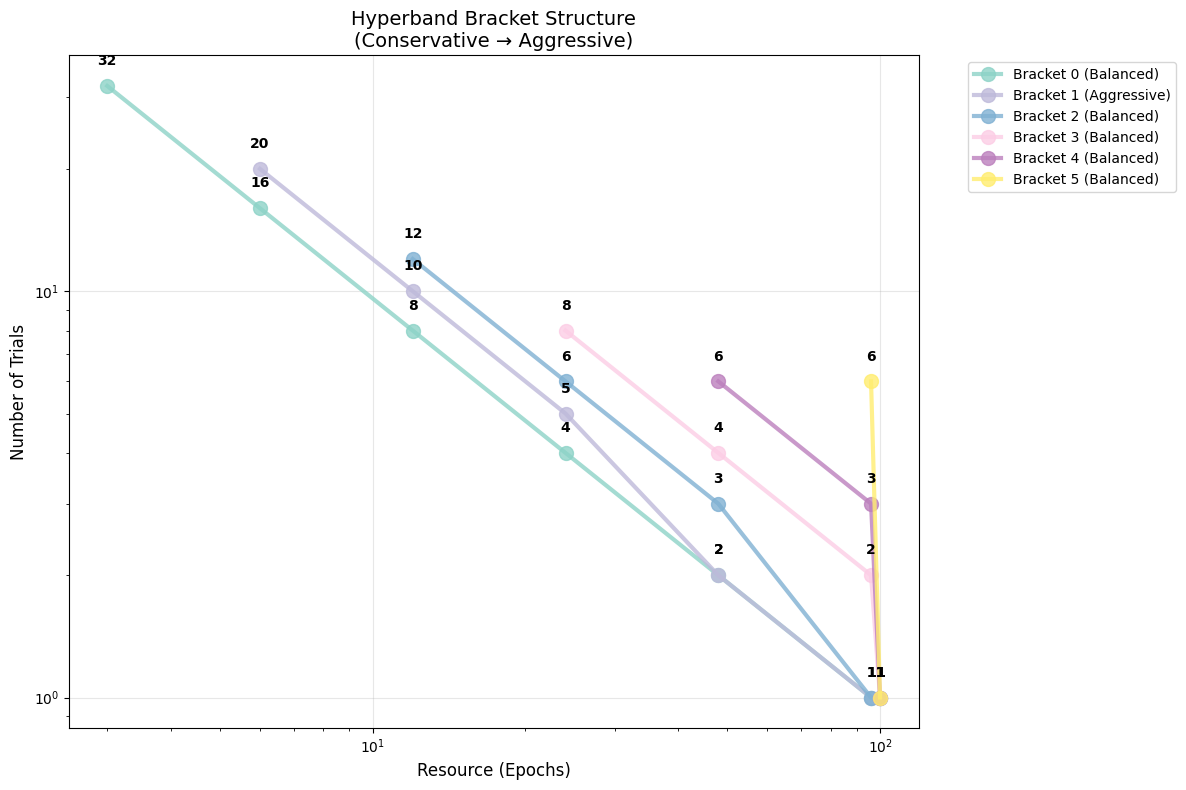

[I 2025-07-27 21:56:27,975] A new study created in memory with name: no-name-7395499e-19c9-4bc2-9826-fe72643494a1


   0%|          | 00:00/05:00

[I 2025-07-27 21:56:28,021] Trial 0 finished with value: 7.297689223135261 and parameters: {'x': -1.254598811526375, 'y': 4.507143064099161, 'lr': 0.015702970884055395, 'resource': 3}. Best is trial 0 with value: 7.297689223135261.
[I 2025-07-27 21:56:28,024] Trial 1 finished with value: 4.2685851162888 and parameters: {'x': 0.986584841970366, 'y': -3.439813595575635, 'lr': 0.00029375384576328325, 'resource': 3}. Best is trial 1 with value: 4.2685851162888.
[I 2025-07-27 21:56:28,027] Trial 2 finished with value: 10.979804621515429 and parameters: {'x': -4.419163878318005, 'y': 3.6617614577493516, 'lr': 0.006358358856676255, 'resource': 3}. Best is trial 1 with value: 4.2685851162888.
[I 2025-07-27 21:56:28,030] Trial 3 finished with value: 9.112570736429017 and parameters: {'x': 2.0807257779604544, 'y': -4.7941550570419755, 'lr': 0.0812324508558869, 'resource': 3}. Best is trial 1 with value: 4.2685851162888.
[I 2025-07-27 21:56:28,032] Trial 4 finished with value: 6.44226500248725 an

In [3]:
import optuna
from hyperband_sampler import HyperbandSampler # custom wrapper

# Define objective function with resource parameter
def objective(trial):
    x = trial.suggest_float("x", -5, 5)
    y = trial.suggest_float("y", -5, 5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    epochs = trial.suggest_int("resource", 1, 100)

    loss = (x**2 + y**2) * (1.0 / epochs) + learning_rate * 0.1
    return loss  # Minimize this

# Instantiate the Hyperband sampler
sampler = HyperbandSampler(
    min_resource=3,
    max_resource=100,
    reduction_factor=2
)
sampler.visualize_brackets()

# Create study with the sampler and resource name
study = optuna.create_study(
    direction='minimize',
    sampler=sampler
)

from optuna.exceptions import TrialPruned

try:
    study.optimize(
        objective,
        timeout=300,
        catch=(TrialPruned,),
        show_progress_bar=True
    )
except TrialPruned:
    print("A trial was pruned and caught outside optimize (optional).")
except Exception as e:
    print(f"Unexpected exception: {e}")


# Print best result
print(f"Best value: {study.best_value}")
print(f"Best params: {study.best_params}")


## Hyperband Configuration Comparison

This experiment compares different `reduction_factor` values (2, 3, 4, 5) on the UCI Letter Recognition dataset. Each configuration runs 3 times with different random seeds to ensure reliable results. We're testing how aggressive elimination vs exploratory search affects optimization performance within a fixed resource budget.

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import optuna
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
import time

# 6) Create Hyperband study
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

import sys
import os
for r in [2,3,4,5]:
    seeds = [0,100,200,300]

    output_dir = f"results/HYPERBAND"
    os.makedirs(output_dir, exist_ok=True)

    output = f"results/HYPERBAND/r={r}"
    os.makedirs(output, exist_ok=True)
    
    # Now import the class
    from hyperband_sampler import HyperbandStudy
    
    for i in [1,2,3]:
        # 1) Grid definition
        param_grid = {
            "n_layers":      [1, 2, 3],
            "n_units_l0":    list(range(32, 129, 32)),
            "n_units_l1":    list(range(32, 129, 32)),
            "n_units_l2":    list(range(32, 129, 32)),
            "batch_size":    list(range(32, 129, 32)),
            "learning_rate": [1e-4, 1e-3, 1e-2],
        }
    
        # 2) Data prep
        X, y = fetch_openml('letter', version=1, return_X_y=True, as_frame=False)
        X = StandardScaler().fit_transform(X.astype('float32'))
        y = LabelEncoder().fit_transform(y)
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=i
        )
        train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr))
        test_ds  = TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
        # 3) Model
        class OptunaLetterNet(nn.Module):
            def __init__(self, trial):
                super().__init__()
                n_layers = trial.suggest_categorical("n_layers", param_grid["n_layers"])
                hidden = []
                if n_layers >= 1:
                    hidden.append(trial.suggest_categorical("n_units_l0", param_grid["n_units_l0"]))
                if n_layers >= 2:
                    hidden.append(trial.suggest_categorical("n_units_l1", param_grid["n_units_l1"]))
                if n_layers >= 3:
                    hidden.append(trial.suggest_categorical("n_units_l2", param_grid["n_units_l2"]))
                layers = []
                in_dim = 16
                for h in hidden:
                    layers.append(nn.Linear(in_dim, h)); in_dim = h
                self.layers = nn.ModuleList(layers)
                self.output = nn.Linear(in_dim, 26)
                self.activation = F.relu
            def forward(self, x):
                for layer in self.layers:
                    x = self.activation(layer(x))
                return self.output(x)
    
        # 4) Objective (modified for Hyperband)
        def objective(trial):
            model = OptunaLetterNet(trial).to(device)
            lr = trial.suggest_categorical("learning_rate", param_grid["learning_rate"])
            bs = trial.suggest_categorical("batch_size", param_grid["batch_size"])
            
            # Resource parameter controlled by Hyperband
            epochs = trial.suggest_int("resource", 1, 100)
            
            train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
            test_loader  = DataLoader(test_ds, batch_size=bs, shuffle=False)
            opt = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss(reduction='sum')
            
            # Train for the number of epochs determined by Hyperband
            for _ in range(int(epochs)):
                model.train()
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    opt.zero_grad(); loss_fn(model(xb), yb).backward(); opt.step()
            
            # Evaluate
            model.eval()
            correct = total = 0
            losses = []
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    outputs = model(xb)
                    preds = outputs.argmax(dim=1)
                    loss = loss_fn(outputs, yb).item()
                    losses.append(loss)
                    correct += (preds == yb).sum().item()
                    total   += yb.size(0)
            accuracy = correct / total
            avg_loss = sum(losses) / total
            trial.set_user_attr('loss', avg_loss)
            return accuracy
    
        optuna.logging.set_verbosity(optuna.logging.WARNING)
    
        # 6) Create Hyperband study
        hyperband_study = HyperbandStudy( #approx 1.5 hours total
            directions="maximize",
            min_resource=3, 
            max_resource=30, 
            reduction_factor=r,
            hyperband_iterations=55,
            sampler_seed=seeds[i],
            
        )
    
        # Show bracket structure
        print("Hyperband bracket structure:")
        print(f"Total trials needed: {hyperband_study.n_trials}")
        for j, bracket in enumerate(hyperband_study.sampler._brackets):
            print(f"Bracket {j}: {len(bracket['rungs'])} rungs")
            for k, rung in enumerate(bracket['rungs']):
                print(f"  Rung {k}: {rung['n_configs']} trials × {rung['resource']} epochs")
    
        # 7) Prepare logging and run optimization
        results = []
        pbar = tqdm(total=hyperband_study.n_trials, desc="Hyperband Optimization")
    
        def logging_callback(study, trial):
        # record this trial's params + value
            entry = trial.params.copy()
            entry["accuracy"] = trial.value
            entry["trial_number"] = trial.number
            entry["trial_end"] = time.time()
            entry["loss"] = trial.user_attrs['loss']
            results.append(entry)
            pbar.update(1)
    
        # Add callback and run
        TIMEOUT = 30 * 60 
        study = hyperband_study.optimize(objective=objective, callbacks=[logging_callback], n_jobs=1, timeout=TIMEOUT)  # This handles TrialPruned gracefully
        pbar.close()
        
        # 8) Save results to JSON
        with open(f"results/HYPERBAND/r={r}/results_{i}.json", "w") as f:
            json.dump(results, f, indent=2)

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 2145
Bracket 0: 5 rungs
  Rung 0: 8 trials × 3 epochs
  Rung 1: 4 trials × 6 epochs
  Rung 2: 2 trials × 12 epochs
  Rung 3: 1 trials × 24 epochs
  Rung 4: 1 trials × 30 epochs
Bracket 1: 4 rungs
  Rung 0: 6 trials × 6 epochs
  Rung 1: 3 trials × 12 epochs
  Rung 2: 1 trials × 24 epochs
  Rung 3: 1 trials × 30 epochs
Bracket 2: 3 rungs
  Rung 0: 4 trials × 12 epochs
  Rung 1: 2 trials × 24 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 3: 2 rungs
  Rung 0: 4 trials × 24 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/2145 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 2145
Bracket 0: 5 rungs
  Rung 0: 8 trials × 3 epochs
  Rung 1: 4 trials × 6 epochs
  Rung 2: 2 trials × 12 epochs
  Rung 3: 1 trials × 24 epochs
  Rung 4: 1 trials × 30 epochs
Bracket 1: 4 rungs
  Rung 0: 6 trials × 6 epochs
  Rung 1: 3 trials × 12 epochs
  Rung 2: 1 trials × 24 epochs
  Rung 3: 1 trials × 30 epochs
Bracket 2: 3 rungs
  Rung 0: 4 trials × 12 epochs
  Rung 1: 2 trials × 24 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 3: 2 rungs
  Rung 0: 4 trials × 24 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/2145 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 2145
Bracket 0: 5 rungs
  Rung 0: 8 trials × 3 epochs
  Rung 1: 4 trials × 6 epochs
  Rung 2: 2 trials × 12 epochs
  Rung 3: 1 trials × 24 epochs
  Rung 4: 1 trials × 30 epochs
Bracket 1: 4 rungs
  Rung 0: 6 trials × 6 epochs
  Rung 1: 3 trials × 12 epochs
  Rung 2: 1 trials × 24 epochs
  Rung 3: 1 trials × 30 epochs
Bracket 2: 3 rungs
  Rung 0: 4 trials × 12 epochs
  Rung 1: 2 trials × 24 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 3: 2 rungs
  Rung 0: 4 trials × 24 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/2145 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 1375
Bracket 0: 4 rungs
  Rung 0: 9 trials × 3 epochs
  Rung 1: 3 trials × 9 epochs
  Rung 2: 1 trials × 27 epochs
  Rung 3: 1 trials × 30 epochs
Bracket 1: 3 rungs
  Rung 0: 5 trials × 9 epochs
  Rung 1: 1 trials × 27 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 2: 2 rungs
  Rung 0: 3 trials × 27 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/1375 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 1375
Bracket 0: 4 rungs
  Rung 0: 9 trials × 3 epochs
  Rung 1: 3 trials × 9 epochs
  Rung 2: 1 trials × 27 epochs
  Rung 3: 1 trials × 30 epochs
Bracket 1: 3 rungs
  Rung 0: 5 trials × 9 epochs
  Rung 1: 1 trials × 27 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 2: 2 rungs
  Rung 0: 3 trials × 27 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/1375 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 1375
Bracket 0: 4 rungs
  Rung 0: 9 trials × 3 epochs
  Rung 1: 3 trials × 9 epochs
  Rung 2: 1 trials × 27 epochs
  Rung 3: 1 trials × 30 epochs
Bracket 1: 3 rungs
  Rung 0: 5 trials × 9 epochs
  Rung 1: 1 trials × 27 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 2: 2 rungs
  Rung 0: 3 trials × 27 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/1375 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 495
Bracket 0: 3 rungs
  Rung 0: 4 trials × 3 epochs
  Rung 1: 1 trials × 12 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 1: 2 rungs
  Rung 0: 2 trials × 12 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/495 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all br

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 495
Bracket 0: 3 rungs
  Rung 0: 4 trials × 3 epochs
  Rung 1: 1 trials × 12 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 1: 2 rungs
  Rung 0: 2 trials × 12 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/495 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all br

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 495
Bracket 0: 3 rungs
  Rung 0: 4 trials × 3 epochs
  Rung 1: 1 trials × 12 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 1: 2 rungs
  Rung 0: 2 trials × 12 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/495 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all br

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 550
Bracket 0: 3 rungs
  Rung 0: 5 trials × 3 epochs
  Rung 1: 1 trials × 15 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 1: 2 rungs
  Rung 0: 2 trials × 15 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/550 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all br

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 550
Bracket 0: 3 rungs
  Rung 0: 5 trials × 3 epochs
  Rung 1: 1 trials × 15 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 1: 2 rungs
  Rung 0: 2 trials × 15 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/550 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all br

/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Hyperband bracket structure:
Total trials needed: 550
Bracket 0: 3 rungs
  Rung 0: 5 trials × 3 epochs
  Rung 1: 1 trials × 15 epochs
  Rung 2: 1 trials × 30 epochs
Bracket 1: 2 rungs
  Rung 0: 2 trials × 15 epochs
  Rung 1: 1 trials × 30 epochs


Hyperband Optimization:   0%|          | 0/550 [00:00<?, ?it/s]

Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all brackets.
Hyperband algorithm has completed all br

## Load Experiment Results

Loading all the JSON result files from our Hyperband experiment runs. Each file contains the trial-by-trial results for different reduction factor configurations across multiple random seeds.

## Analyze and Visualize Results

Processing the raw results to compare how different reduction factors perform over time. We're tracking the best accuracy and lowest loss achieved so far at each point during optimization, showing the real-time performance of each Hyperband configuration.

In [5]:
import os
import json
import pandas as pd

base_path = "/kaggle/input/hyperbandresults/results/HYPERBAND"

all_records = []
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith(".json"):
            full_path = os.path.join(root, file)
            with open(full_path, "r") as f:
                try:
                    data = json.load(f)
                    all_records.append({
                        "path": full_path,
                        "results": data
                    })
                except Exception as e:
                    print(f"Failed to load {full_path}: {e}")

print(f"Loaded {len(all_records)} result files.")


Loaded 12 result files.


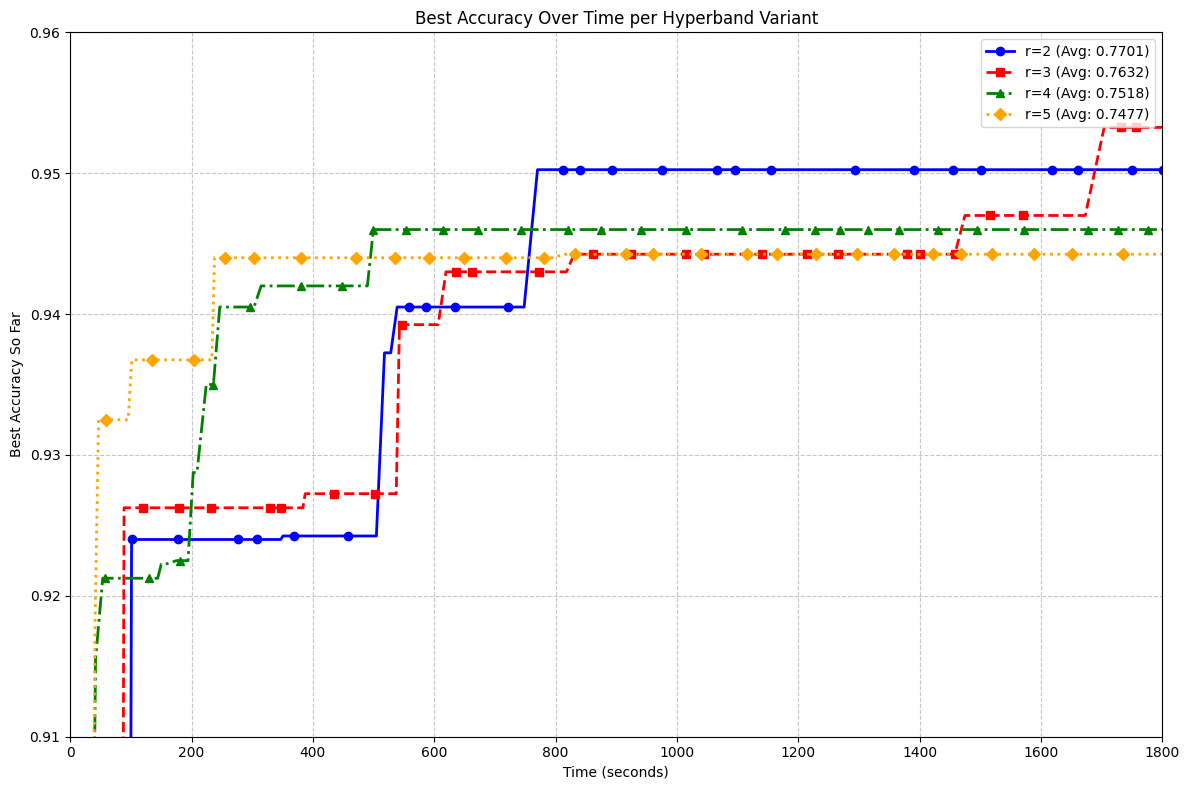

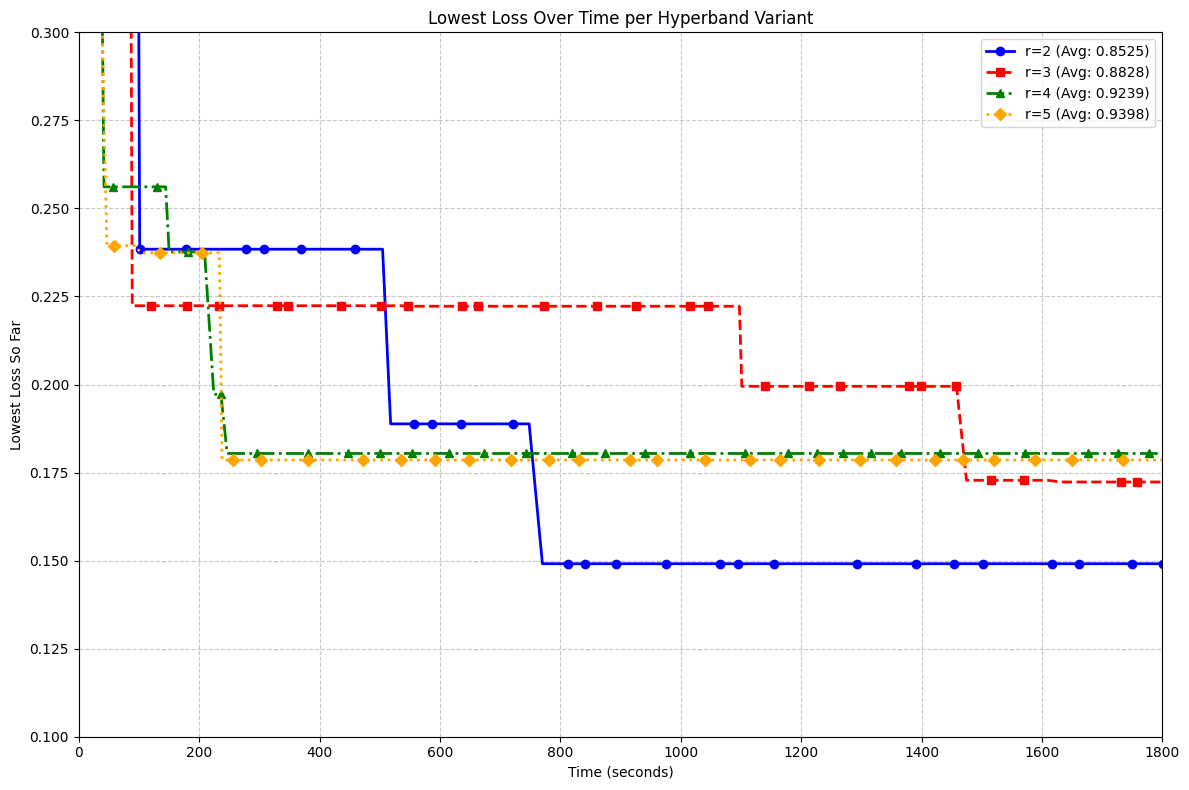

In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Build hyperband_results from all_records
hyperband_results = defaultdict(lambda: {
    "accuracies": [],
    "losses": [],
    "time_acc_pairs": [],
    "time_loss_pairs": []
})

MAX_TIME = 30 * 60  # Limit to first 1.5 hours
hyperband_variants = ['r=2', 'r=3', 'r=4', 'r=5']

for record in all_records:
    variant = [part for part in record["path"].split("/") if part.startswith("r=")][0]
    for entry in record["results"]:
        t = entry.get("trial_end")
        acc = entry.get("accuracy")
        loss = entry.get("loss")
        if t is not None and acc is not None and loss is not None:
            hyperband_results[variant]["accuracies"].append(acc)
            hyperband_results[variant]["losses"].append(loss)
            hyperband_results[variant]["time_acc_pairs"].append((t, acc))
            hyperband_results[variant]["time_loss_pairs"].append((t, loss))

# Calculate aggregates
for variant in hyperband_variants:
    accs = hyperband_results[variant]['accuracies']
    losses = hyperband_results[variant]['losses']
    hyperband_results[variant]['avg_accuracy'] = np.mean(accs) if accs else 0
    hyperband_results[variant]['std_accuracy'] = np.std(accs) if accs else 0
    hyperband_results[variant]['avg_loss'] = np.mean(losses) if losses else float('inf')
    hyperband_results[variant]['std_loss'] = np.std(losses) if losses else 0

# Visualization styles
colors = {'r=2': 'blue', 'r=3': 'red', 'r=4': 'green', 'r=5': 'orange'}
line_styles = {'r=2': '-', 'r=3': '--', 'r=4': '-.', 'r=5': ':'}
marker_styles = {'r=2': 'o', 'r=3': 's', 'r=4': '^', 'r=5': 'D'}

# Plot Best Accuracy So Far
plt.figure(figsize=(12, 8))
for variant in hyperband_variants:
    pairs = sorted(hyperband_results[variant]['time_acc_pairs'])
    if not pairs:
        continue
    times = np.array([(t - min(t for t, _ in pairs)) for t, _ in pairs])
    accs = np.array([a for _, a in pairs])
    best_so_far = np.maximum.accumulate(accs)
    plt.plot(times, best_so_far,
             label=f"{variant} (Avg: {hyperband_results[variant]['avg_accuracy']:.4f})",
             color=colors[variant],
             linestyle=line_styles[variant],
             marker=marker_styles[variant],
             markevery=10,
             linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Best Accuracy So Far")
plt.title("Best Accuracy Over Time per Hyperband Variant")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, MAX_TIME)
plt.ylim(0.91, 0.96)
plt.tight_layout()
plt.savefig("best_accuracy_over_time.png")  # 🔽 Save this plot
plt.show()

# Plot Best Loss So Far
plt.figure(figsize=(12, 8))
for variant in hyperband_variants:
    pairs = sorted(hyperband_results[variant]['time_loss_pairs'])
    if not pairs:
        continue
    times = np.array([(t - min(t for t, _ in pairs)) for t, _ in pairs])
    losses = np.array([l for _, l in pairs])
    best_so_far = np.minimum.accumulate(losses)
    plt.plot(times, best_so_far,
             label=f"{variant} (Avg: {hyperband_results[variant]['avg_loss']:.4f})",
             color=colors[variant],
             linestyle=line_styles[variant],
             marker=marker_styles[variant],
             markevery=10,
             linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Lowest Loss So Far")
plt.title("Lowest Loss Over Time per Hyperband Variant")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, MAX_TIME)
plt.ylim(0.1, 0.3)
plt.tight_layout()
plt.savefig("lowest_loss_over_time.png")  # 🔽 Save this plot
plt.show()
